# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

In [8]:
# Define transforms
train_transform = transforms.Compose([transforms.Resize(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

# Create the train, valid and test set
train_data = torchvision.datasets.CIFAR10('data/train/', transform=train_transform, train=True, download=True)
valid_data = torchvision.datasets.CIFAR10('data/valid/', transform=valid_transform, train=True,download=True)
test_data = torchvision.datasets.CIFAR10('data/test/', transform=test_transform, train=False, download=True)


# Define the train, valid and test dataLoader
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.1*num_train))

np.random.seed(100)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

horse


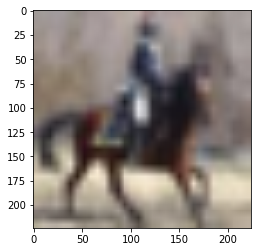

car


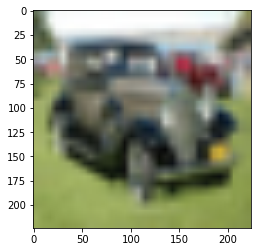

car


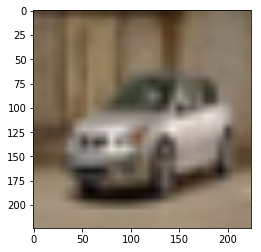

bird


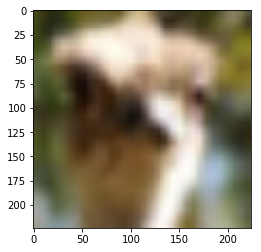

cat


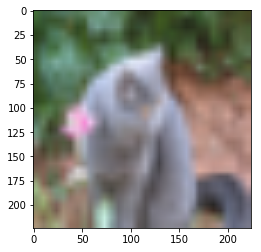

In [7]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
model = torchvision.models.densenet121(pretrained=True)
model

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:03<00:00, 10548984.20it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [10]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(512, 10)),
                          ('output', nn.Softmax(dim=1))
                          ]))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.classifier = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
train_losses, valid_losses, accuracies = [],[],[]
epochs = 10
print_every = 100


for e in range(epochs):
    steps = 0
    running_loss = 0
    print(f"Epoch {e+1}/{epochs}:")
    print("----------")
    
    for images, labels in train_loader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        ps = model.forward(images)
        loss = criterion(ps, labels)        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(f"Current training loss for batch {steps}: {running_loss/steps:.3f}"
                  f" ")
    
    else:
        valid_loss = 0
        accuracy = 0
        model.eval()
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                ps = model.forward(inputs)
                batch_loss = criterion(ps, labels)

                valid_loss += batch_loss.item()

                # Calculate accuracy
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        model.train()
        
        print(f"Training loss: {running_loss/len(train_loader):.3f} | "
              f"Validation loss: {valid_loss/len(valid_loader):.3f} | "
              f"Validation accuracy: {accuracy/len(valid_loader):.3f}"
              f" ")
            
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        accuracies.append(accuracy/len(valid_loader))
    

Epoch 1/10:
----------
Current training loss for batch 100: 2.264 
Current training loss for batch 200: 2.263 
Current training loss for batch 300: 2.262 
Training loss: 2.262 | Validation loss: 2.264 | Validation accuracy: 0.195 
Epoch 2/10:
----------
Current training loss for batch 100: 2.163 
Current training loss for batch 200: 2.089 
Current training loss for batch 300: 2.044 
Training loss: 2.027 | Validation loss: 1.933 | Validation accuracy: 0.527 
Epoch 3/10:
----------
Current training loss for batch 100: 1.946 
Current training loss for batch 200: 1.936 
Current training loss for batch 300: 1.913 
Training loss: 1.908 | Validation loss: 1.891 | Validation accuracy: 0.569 
Epoch 4/10:
----------
Current training loss for batch 100: 1.853 
Current training loss for batch 200: 1.831 
Current training loss for batch 300: 1.805 
Training loss: 1.795 | Validation loss: 1.735 | Validation accuracy: 0.722 
Epoch 5/10:
----------
Current training loss for batch 100: 1.730 
Current t

Plot the training loss (and validation loss/accuracy, if recorded).

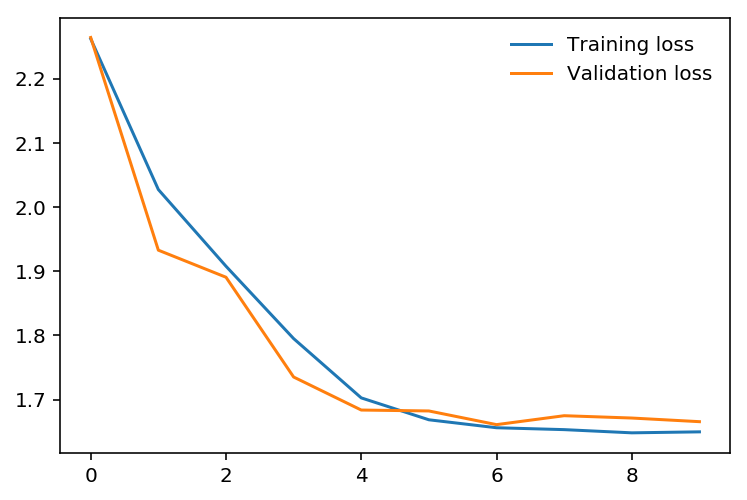

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
test_loss = 0
accuracy = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        ps = model.forward(images)
        test_loss += criterion(ps, labels)

        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print("Test Loss: {:.3f} | ".format(test_loss/len(test_loader)),
  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Test Loss: 1.662 |  Test Accuracy: 0.798


## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
checkpoint = {'input_size': 3072,
              'output_size': 10,
              'model_architecture': model._modules,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'cifar10_densenet_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

I would recommend to build the model instead of buying as the model built has a final accuracy of 79.8% on the testing set which is almost 10% higher than Detectocorp's model. Although it did not perform as good as most other advanced solutions in the literature with accuracy score above the 90.0% mark, it does outperform [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf) by around 1%.

Inititally, a relatively simple feedforward neural network was built but it was clearly not enough to beat the Detectocorp's model as it hovers at sub 50.0% accuracy. Then, the current model was built and achieved the 79.8% accuracy score through utilising Transfer Learning with DenseNet-121, tweaking of the learning rate of the optimiser and playing around with different numbers of hidden layers. 

Because the model is going to be adapted for a self-driving car, it is very important to have a very high accuracy in order to ensure the safety of the passenger in the car. Therefore, we can attempt to improve the accuracy by applying the methods used papers like [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf) and [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf) which have achieved an impressive accuracy score of around 99.0%.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).